In [9]:

import os
import sys
current_dir = os.path.dirname(os.path.abspath('.'))
sys.path.append(current_dir)


from SINKT.agents import QuestionAgent
from SINKT.models import (
    KnowledgeGraphModel, 
    Concept,
    Relation,
)
from SINKT.utils import (get_llm, Models)
from SINKT.knowledge_graph import GraphSelector, GraphXMLBuilder
from SINKT.simulator import StudentSimulator


Running simulation for 1000 steps...


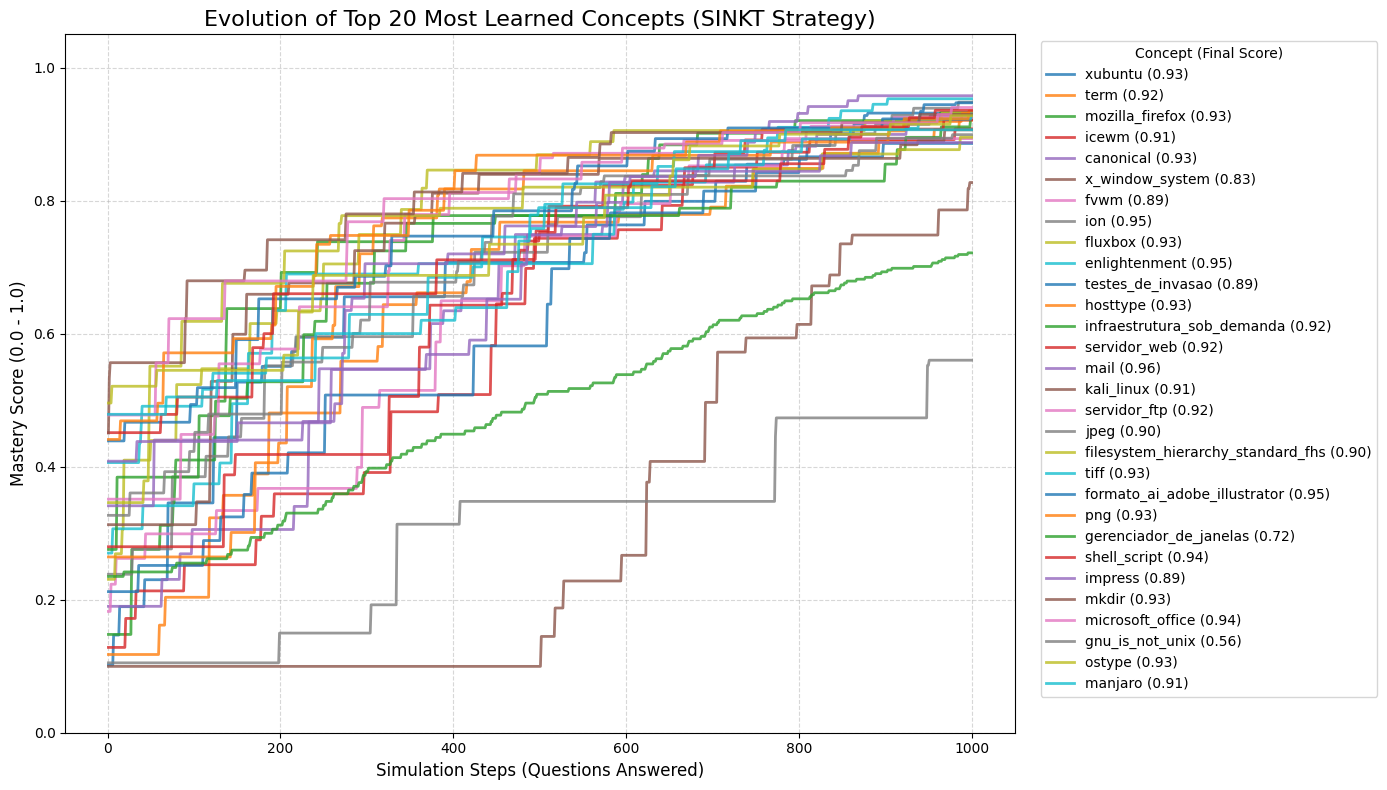

In [ ]:


from SINKT.agents import QuestionAgent
from SINKT.models import (
    KnowledgeGraphModel, 
    Concept,
    Relation,
)
from SINKT.utils import (get_llm, Models)
from SINKT.knowledge_graph import GraphSelector, GraphXMLBuilder
from SINKT.simulator import StudentSimulator

input_path = Path('.')
xml_builder = GraphXMLBuilder()

if input_path.exists():
    kg_model = xml_builder.load(input_path)

    # Initialize Simulator
    sim = StudentSimulator(kg_model)

    # Run Simulation
    # This will generate data following your specific SINKT notebook logic
    data = sim.run_session(n_attempts=1000)

    # Display Results
    df = pd.DataFrame(data)
    
    # Run a longer session to see evolution
    # history_df = sim.run_session(n_attempts=200)
    
    # Generate the Plot
    plot_top_concepts(data, sim.graph)
    
    # print("\n--- Student Learning Path ---")
    # # Show columns relevant to your notebook strategy
    # cols = ['time', 'concept', 'mastery_before', 'prereq_factor_fi', 'outcome', 'mastery_after']
    # display(df[cols].head(15))
    
    # # Optional: Check if student got stuck due to prerequisites (low fi)
    # low_fi = df[df['prereq_factor_fi'] < 0.5]
    # if not low_fi.empty:
    #     print(f"\nStruggled due to prerequisites {len(low_fi)} times.")
else:
    print("Please ensure XML files are created.")

In [10]:
import matplotlib.pyplot as plt
# --- 3. PLOTTING LOGIC ---
def plot_top_concepts(history_df, graph_structure):
    # Prepare Data
    if '__step__' not in history_df.columns:
        history_df['__step__'] = range(len(history_df))
    
    df_plot = history_df.set_index('__step__')
    
    # Calculate Total Learning Gain (Final - Initial)
    # We filter out non-concept columns first
    concept_cols = [c for c in df_plot.columns if c in graph_structure.nodes]
    gains = df_plot[concept_cols].iloc[-1] - df_plot[concept_cols].iloc[0]
    
    # Get Top 20
    top_20_concepts = gains.sort_values(ascending=False).head(30).index.tolist()
    
    # Plot
    plt.figure(figsize=(14, 8))
    
    # Plot background lines (faint) for context? No, just top 20 to keep it clean.
    for concept in top_20_concepts:
        # Get readable name
        name = graph_structure.nodes[concept].get('name', concept)
        final_val = df_plot[concept].iloc[-1]
        
        plt.plot(df_plot.index, df_plot[concept], label=f"{name} ({final_val:.2f})", linewidth=2, alpha=0.8)
    
    plt.title(f"Evolution of Top 20 Most Learned Concepts (SINKT Strategy)", fontsize=16)
    plt.xlabel("Simulation Steps (Questions Answered)", fontsize=12)
    plt.ylabel("Mastery Score (0.0 - 1.0)", fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Concept (Final Score)")
    plt.tight_layout()
    plt.show()

In [2]:
import os
import sys
current_dir = os.path.dirname(os.path.abspath('.'))
sys.path.append(current_dir)
import pandas as pd
from pathlib import Path
import random
from dotenv import load_dotenv
from langsmith.wrappers import wrap_openai
from openai import OpenAI

from SINKT.agents import QuestionAgent
from SINKT.models import (
    KnowledgeGraphModel, 
    Concept,
    Relation,
)
from SINKT.utils import (get_llm, Models)
from SINKT.knowledge_graph import GraphSelector, GraphXMLBuilder
from SINKT.simulator import StudentSimulator
from SINKT.student import StudentFactory
from SINKT.population import PopulationSimulator

load_dotenv('../.env')

assert os.getenv("OPENAI_API_KEY"), "OPENAI_API_KEY not found"
assert os.getenv("ANTHROPIC_API_KEY"), "ANTHROPIC_API_KEY not found"
assert os.getenv("LANGSMITH_API_KEY"), "ANTHROPIC_API_KEY not found"
client = wrap_openai(OpenAI())

In [3]:
def generate_synthetic_dataset(n_students=100):
    xml_builder = GraphXMLBuilder()
    input_path = Path(".")
    
    if not input_path.exists():
        print("Data path not found.")
        return None

    kg_model = xml_builder.load(input_path)
    sim = PopulationSimulator(kg_model)
    
    all_data = []
    print(f"Generating data for {n_students} students...")
    
    for i in range(1, n_students + 1):
        # Create unique profile
        profile = StudentFactory.create_student(i)
        
        # Random sequence length (30-60 interactions)
        n_steps = random.randint(1, 10)
        
        # Run Session
        student_history = sim.run_student_session(profile, n_steps, explain_error=True)
        all_data.extend(student_history)
        
        if i % 10 == 0:
            print(f"Processed {i} students...")
            
    df = pd.DataFrame(all_data)
    return df

In [4]:
df_population = generate_synthetic_dataset(n_students=1)

if df_population is not None:
    print("\n--- Dataset Generation Complete ---")
    print(f"Total Interactions: {len(df_population)}")
    print("\nSample Data:")
    display(df_population[['student_id', 'archetype', 'step', 'question_id', 'outcome', 'p_correct_observed']].head())
    
    # Save to CSV
    df_population.to_csv("synthetic_student_population.csv", index=False)
    print("Saved to synthetic_student_population.csv")

Generating data for 1 students...


====================================================================================================

QuestionSchema(
    text='Você precisa localizar todos os arquivos `.log` maiores que 5 MB dentro do diretório `/var` e seus 
subdiretórios, exibindo apenas o caminho completo de cada arquivo encontrado. Qual dos comandos abaixo atende a 
esse requisito?',
    option=[
        'find /var -name "*.log" -size +5M -print',
        'find /var -type f -name "*.log" -size +5M -print',
        'find /var -type f -name "*.log" -size +5M',
        'find /var -name "*.log" -size +5M -ls'
    ],
    correct_answer=1,
    context='A questão avalia o uso do comando `find` no Linux, incluindo filtros por tipo de arquivo, padrão de 
nome e tamanho, bem como a forma padrão de exibir o caminho completo dos arquivos encontrados.',
    main_concept_id='linux',
    specific_concept_id='find'
)

MAIN MASTERY (linux): 0.07279768799725002
SPECIFIC MASTERY (find): 0.3485975639851618

====================================================================================================

EXPLANATION: O comando escolhido (`find /var -type f -name "*.log" -size +5M`) encontra os arquivos corretos, mas 
não garante explicitamente a exibição do caminho completo, pois omite a ação `-print` solicitada no enunciado. 
Embora `find` normalmente imprima o caminho por padrão, a questão está testando o conhecimento preciso das opções, 
especialmente `-print` para exibir o caminho completo. A alternativa correta inclui explicitamente `-print`. Dado o
baixo domínio em linux e find e o fato de o aluno ter escolhido uma opção tecnicamente incompleta segundo o que o 
enunciado pede, o erro indica falta de conhecimento detalhado do uso das flags do `find`, não apenas distração ou 
leitura equivocada.
ERROR_TYPE: lack_of_concept_knowledge

====================================================================================================

QuestionSchema(
    text='Você está administrando um servidor Slackware Linux e precisa disponibilizar arquivos para clientes 
externos por meio de FTP. Considerando uma instalação padrão do Slackware e o uso de software tradicional do 
sistema, qual é a opção mais adequada para configurar um servidor FTP simples, estável e alinhado à filosofia 
Slackware?',
    option=[
        'Instalar e configurar o vsftpd a partir do repositório oficial de pacotes do Slackware',
        'Habilitar e configurar o servidor ProFTPD que já vem pré-instalado e integrado ao sistema',
        'Instalar o FileZilla Server via Wine para oferecer FTP em modo gráfico',
        'Ativar o servidor FTP embutido no gerenciador de arquivos do KDE (Dolphin) para ser acessado externamente'
    ],
    correct_answer=1,
    context='A distribuição Slackware Linux segue uma filosofia de simplicidade e uso de softwares tradicionais e 
bem testados. Para oferecer serviços de FTP, é comum utilizar servidores já incluídos na árvore de pacotes 
principal ou facilmente configuráveis via scripts padrão do sistema. O ProFTPD é frequentemente disponibilizado em 
Slackware e integra-se bem ao estilo de configuração baseado em arquivos de texto e scripts de inicialização em 
/etc/rc.d, o que facilita a criação de um servidor FTP estável e simples de administrar.',
    main_concept_id='slackware_linux',
    specific_concept_id='servidor_ftp'
)

MAIN MASTERY (slackware_linux): 0.07279768799725002
SPECIFIC MASTERY (servidor_ftp): 0.5417243419041786

====================================================================================================

EXPLANATION: O aluno escolheu instalar o FileZilla Server via Wine, uma solução gráfica típica de Windows, que não 
faz parte do ecossistema tradicional do Slackware, nem segue a filosofia de simplicidade e uso de ferramentas 
nativas. A resposta correta exige reconhecer qual servidor FTP é típico/adequado em um Slackware padrão. A 
alternativa marcada mostra desconhecimento de como se implementa FTP em Slackware (quais servidores são usualmente 
usados e como a filosofia da distribuição privilegia soluções simples, nativas e em modo texto), e não apenas uma 
leitura equivocada ou distração. Isso caracteriza falta de conhecimento conceitual sobre o ambiente Slackware e 
suas ferramentas padrão, mais do que um mero deslize ou erro de interpretação do enunciado.
ERROR_TYPE: lack_of_concept_knowledge

====================================================================================================

QuestionSchema(
    text='No LibreOffice Calc, qual das alternativas descreve corretamente o uso básico da função SOMA?',
    option=[
        'Somar apenas células que contenham texto em uma coluna',
        'Somar valores de um intervalo de células, por exemplo =SOMA(A1:A10)',
        'Somar automaticamente apenas os valores positivos de uma planilha inteira, sem especificar intervalo',
        'Somar valores de duas planilhas diferentes sem necessidade de referência às células'
    ],
    correct_answer=1,
    context='A função SOMA é uma das funções mais utilizadas no LibreOffice Calc para realizar adições de valores 
em intervalos de células. A sintaxe básica é =SOMA(intervalo), onde "intervalo" pode ser algo como A1:A10 ou 
A1;B1;C1.',
    main_concept_id='libreoffice',
    specific_concept_id='calc'
)

MAIN MASTERY (libreoffice): 0.5810321793685975
SPECIFIC MASTERY (calc): 0.34700468108759513

====================================================================================================

EXPLANATION: A função SOMA é uma das funções mais básicas do Calc, e seu uso típico é somar valores de um intervalo
especificado, como =SOMA(A1:A10). O aluno escolheu uma alternativa que descreve um comportamento que a função SOMA 
não tem (somar automaticamente apenas valores positivos da planilha inteira, sem intervalo). Isso indica que não é 
apenas uma distração ou leitura equivocada do enunciado, mas sim um entendimento incorreto sobre como a função 
funciona e é usada. Portanto, o erro é melhor classificado como falta de conhecimento conceitual específico sobre a
função SOMA em Calc, e não como um simples deslize ou falha de atenção.
ERROR_TYPE: lack_of_concept_knowledge

====================================================================================================

QuestionSchema(
    text='Você está criando um folheto no LibreOffice Draw. Precisa inserir uma forma (retângulo) e, depois, 
adicionar um texto dentro dessa forma para que o texto fique integrado ao objeto. Qual é a sequência correta de 
ações para fazer isso?',
    option=[
        'Inserir > Texto e depois clicar em Inserir > Forma > Retângulo',
        'Clicar no ícone de Retângulo na barra de desenho, desenhar a forma e depois clicar duas vezes dentro dela 
para digitar o texto',
        'Formatar > Página > Retângulo e depois Inserir > Texto',
        'Clicar em Inserir > Campo > Retângulo com texto',
        'Criar uma caixa de texto e depois converter automaticamente em forma de retângulo pelo menu Formatar'
    ],
    correct_answer=1,
    context='LibreOffice Draw é o módulo de desenho vetorial do LibreOffice, usado para criar diagramas, folhetos, 
cartazes e outros elementos gráficos. Uma operação básica é inserir formas (como retângulos, círculos) e adicionar 
texto dentro delas, para criar caixas de informação, botões ou rótulos visuais. No Draw, ao criar uma forma pela 
barra de desenho (por exemplo, um retângulo) e depois clicar duas vezes dentro da forma, o usuário pode digitar 
diretamente o texto, que passa a fazer parte do objeto gráfico.',
    main_concept_id='libreoffice',
    specific_concept_id='draw'
)

MAIN MASTERY (libreoffice): 0.5810321793685975
SPECIFIC MASTERY (draw): 0.37384223693057334

====================================================================================================

EXPLANATION: A questão descreve o procedimento padrão do Draw: desenhar o retângulo pela barra de desenho e depois 
digitar dentro dele. O estudante escolheu uma opção de menu inexistente/atípica (“Inserir > Campo > Retângulo com 
texto”), o que indica que interpretou a tarefa como algo a ser feito via menus automáticos em vez de reconhecer o 
fluxo usual de desenhar a forma e editar diretamente o conteúdo. Como o aluno tem domínio moderado em LibreOffice e
Draw, isso não parece falta total de conhecimento, mas sim uma leitura equivocada do que a ferramenta realmente 
oferece e de como o processo ocorre, caracterizando misinterpretation.
ERROR_TYPE: misinterpretation

====================================================================================================

QuestionSchema(
    text='Você está criando um banco de dados simples no LibreOffice Base para registrar empréstimos de livros em 
uma biblioteca. Você já criou as tabelas “Livros” e “Usuários”. Agora precisa garantir que, ao registrar um 
empréstimo, só seja possível selecionar livros e usuários que já existam nessas tabelas. Qual é o tipo de 
objeto/recurso do LibreOffice Base que você deve usar para facilitar essa seleção em um formulário?',
    option=[
        'Criar uma consulta SQL direta e digitar manualmente os IDs',
        'Criar uma tabela extra apenas para armazenar os IDs selecionados',
        'Utilizar uma caixa de listagem (List Box) vinculada às tabelas ‘Livros’ e ‘Usuários’',
        'Usar apenas campos de texto simples para digitar o nome do livro e do usuário'
    ],
    correct_answer=3,
    context='Contexto: Uso do LibreOffice Base para criação de formulários e relacionamento entre tabelas. O foco é
entender que, em formulários do Base, é possível usar controles como caixas de listagem (List Box) para selecionar 
registros existentes em outras tabelas, garantindo integridade dos dados e facilitando a entrada de informações em 
bancos relacionais.',
    main_concept_id='libreoffice',
    specific_concept_id='base'
)

MAIN MASTERY (libreoffice): 0.5810321793685975
SPECIFIC MASTERY (base): 0.37626349181563584

====================================================================================================

EXPLANATION: A questão exige saber que, em formulários do LibreOffice Base, o recurso adequado para selecionar 
apenas registros já existentes em outras tabelas (como Livros e Usuários) é uma caixa de listagem (List Box) 
vinculada. Ao escolher criar uma tabela extra para armazenar os IDs, o estudante demonstra não reconhecer o papel 
típico de List Box em formulários de banco de dados e tenta resolver o problema com uma estrutura de dados 
adicional, o que não é a prática correta. Isso indica dificuldade específica com o conceito de objetos de 
formulário no Base, não apenas distração ou leitura equivocada.
ERROR_TYPE: lack_of_concept_knowledge


--- Dataset Generation Complete ---
Total Interactions: 7

Sample Data:


,student_id,archetype,step,question_id,outcome,p_correct_observed
0,S001,The Gamer,1,find,0,0.526
1,S001,The Gamer,2,servidor_ftp,0,0.612
2,S001,The Gamer,3,xubuntu,1,0.683
3,S001,The Gamer,4,metacity,1,0.532
4,S001,The Gamer,5,calc,0,0.441


Saved to synthetic_student_population.csv
